In [2]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from matplotlib.pyplot import figure
import glob

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
dataset_metadata = { 'yelp': {'n_class': 2, "train_size": 30400, "val_size": 3800, 'metric': 'acc', 'coverage': 0.83}, 
                     'imdb': {'n_class': 2, "train_size": 20000, "val_size": 2500, 'metric': 'acc', 'coverage': 0.88},
                     'trec': {'n_class': 6, "train_size": 4800, "val_size": 500, 'metric': 'acc', 'coverage': 0.95},
                     'youtube': {'n_class': 2,"train_size": 2000, "val_size": 120, 'metric': 'acc', 'coverage': 0.87},
                     'chemprot': {'n_class': 10,"train_size": 12600, "val_size": 1607, 'metric': 'acc', 'coverage': 0.86},
                     'spouse': {"train_size": 22254, "val_size": 2811, 'metric': 'f1_binary', 'coverage': 0.25},
                     'cdr': {"train_size": 8430, "val_size": 920, 'metric': 'f1_binary', 'coverage': 0.907},
                     'amazon31': {'n_class': 31,"train_size": 131781, "val_size": 5805, 'metric': 'acc'},
                      'banking77': {'n_class': 77,"train_size": 9003, "val_size": 1000, 'metric': 'acc'},
                      'massive_lowcard': {"train_size": 11514, "val_size": 2033, 'metric': 'acc'},
                      'dbpedia': {"train_size": 560000, "val_size": 5000, 'metric': 'acc'},
                      'semeval': {'n_class': 9,'train_size': 1749, "val_size": 178, 'metric': 'acc'},
                     'agnews': {'n_class': 4, 'train_size': 96000, "val_size": 12000,'metric': 'acc'}
                   }
result_directory = "results"
datasets = ['yelp', 'trec', 'imdb', 'chemprot', 'agnews', 'semeval']
N_RUNS = 5
PERCENT_TRIAL = 1
label_models = ['majority_voting']
end_models = ['bert_roberta']
size_to_color = {5: "blue", 50: 'black'}
#                   } 
# LM_to_color = { 'majority_voting': 'blue', 
#                 'snorkel': 'orange',
#                 'val_as_train': 'black',
#                 'generative_model': 'green',
#                 'flying_squid': 'red',
#                 'dawid_skene': 'purple'}
# EM_to_color = {'mlp_model' : 'grey',
#                 'bert_classifier_model' : 'yellow'}


## Investigation 1: Validation Set Sizes

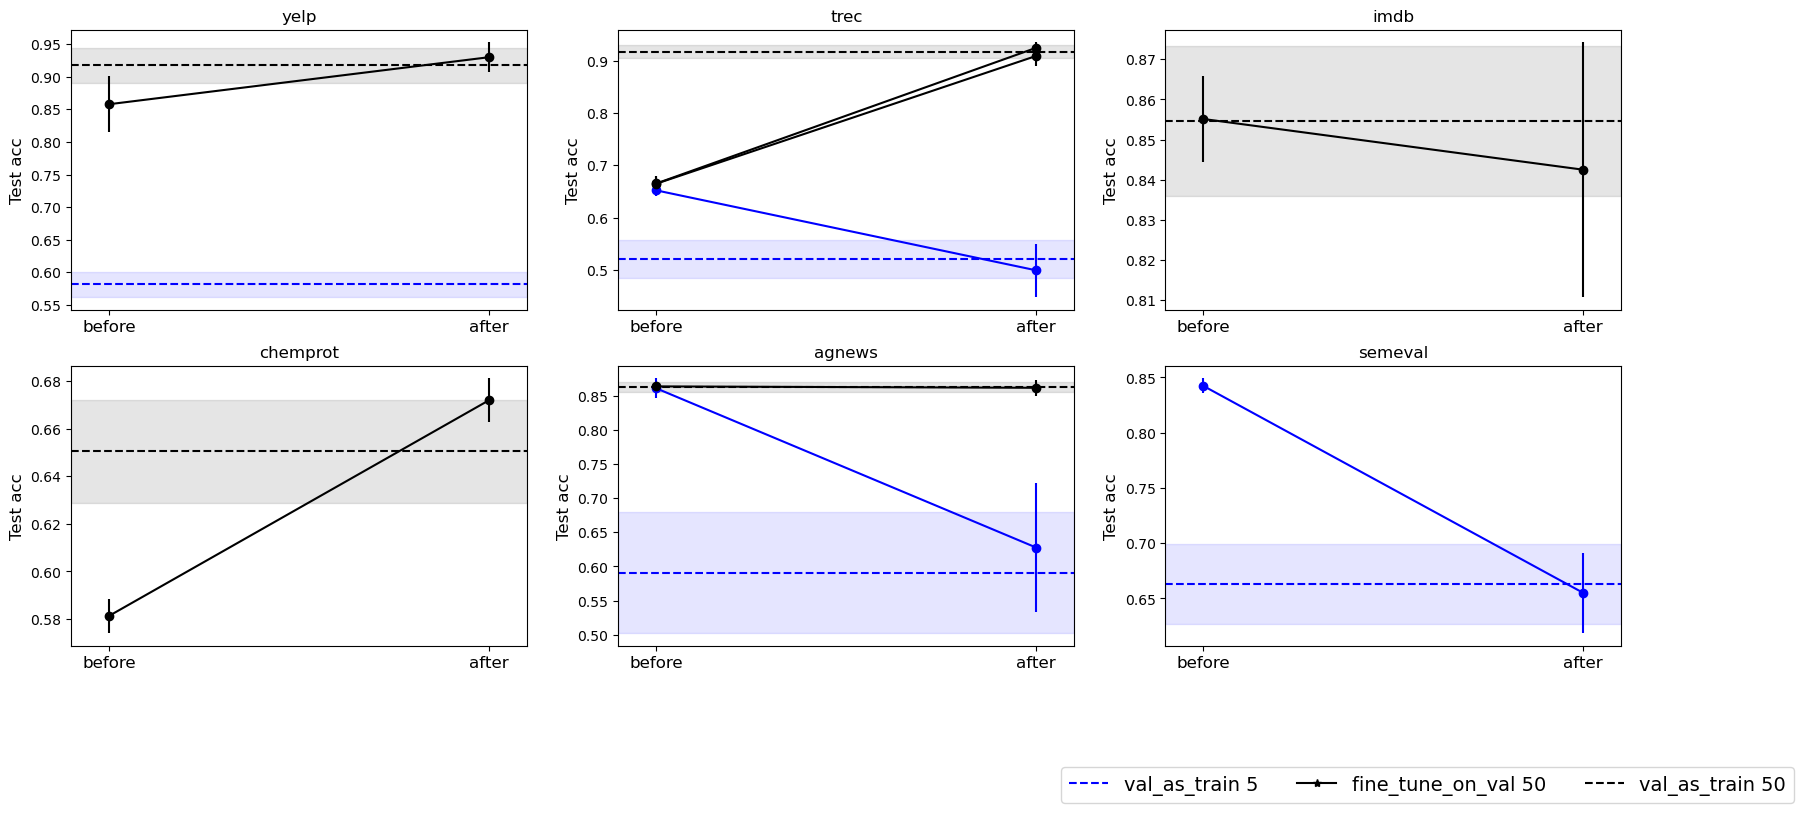

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(20,8))
counter_x = 0
counter_y = 0
for data in datasets:
    files_per_data = glob.glob(f'{result_directory}/{data}/*.json')
    ax = axs[counter_y, counter_x]
    counter_x += 1
    if counter_x == 3:
        counter_x = 0
        counter_y += 1
    ax.set_xticks([0,1], ['before', 'after'], fontsize=12)
    for filepath in files_per_data:
        with open(filepath) as f:
            file =  filepath.split("/")[2].split('.')[0].split("-")
            dataset_name, pip ,LM, EM, _= file
            if EM !="bert_classifier_model_roberta":
                continue
            if pip == 'fine_tune_on_val':
                result_dict = json.load(f)
                x = result_dict.keys()
                val_size = int(list(x)[0])
                em_test = [result_dict[k]["em_test"] for  k in result_dict]
                em_test_mean, em_test_std = zip(*[list(v.values())[0] for v in em_test])
                em_test_se = np.array(em_test_std) / np.sqrt(N_RUNS)

                tuned_em_test = [result_dict[k]["tuned_em_test"] for  k in result_dict]
                tuned_em_test_mean, tuned_em_test_std = zip(*[list(v.values())[0] for v in tuned_em_test])
                tuned_em_test_se = np.array(tuned_em_test_std) / np.sqrt(N_RUNS)

                n_class = dataset_metadata[data]['n_class']
                vpz = val_size//n_class
                ax.plot([0,1], [em_test_mean,tuned_em_test_mean], label =pip + " "+ str(vpz), marker = "*", color = size_to_color[vpz])
                yerr = np.array([em_test_se, tuned_em_test_se])*1.96
                y = np.array([em_test_mean, tuned_em_test_mean])
                for i in [0,1]:
                    ax.errorbar(i,y[i], yerr[i],  xerr=None, fmt="o", color = size_to_color[val_size/n_class])
            if pip == "val_as_train":
                result_dict = json.load(f)
                x = result_dict.keys()
                val_size = int(list(x)[0])
                

                em_test = [result_dict[k]["em_test"] for  k in result_dict]
                em_test_mean, em_test_std = zip(*[list(v.values())[0] for v in em_test])
                em_test_se = np.array(em_test_std) / np.sqrt(N_RUNS)
                x = np.linspace(-0.1, 1.1, 2)

                n_class = dataset_metadata[data]['n_class']

                vpz = val_size//n_class
                ax.plot(x, [em_test_mean] * len(x), label =pip + " "+ str(vpz), color = size_to_color[vpz], linestyle='dashed')
                ax.fill_between(x, em_test_mean  - 1.96* em_test_se, em_test_mean + 1.96* np.array(em_test_se), alpha=0.1, color = size_to_color[val_size/n_class])
    ax.set_xlim((-0.1, 1.1))
    ax.set_title(f"{dataset_name}", fontsize=12)
    ax.set_xlabel("", fontsize=12)
    ax.set_ylabel("Test {}".format(dataset_metadata[data]['metric']), fontsize=12)
    if counter_x == 1 and counter_y == 0:
        ax.legend(ncol=5, bbox_to_anchor=(3.8, -1.60), fontsize = 14)
plt.savefig("cft")